## Example. Comparing Newcomb’s speed of light measurements to the posterior predictive distribution

In [260]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import itertools

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)

%config Inline.figure_formats = ['retina']

The data.

In [2]:
numbs = "28 26 33 24 34 -44 27 16 40 -2 29 22 \
24 21 25 30 23 29 31 19 24 20 36 32 36 28 25 21 28 29 \
37 25 28 26 30 32 36 26 30 22 36 23 27 27 28 27 31 27 26 \
33 26 32 32 24 39 28 24 25 32 25 29 27 28 29 16 23"

In [3]:
nums = np.array([int(i) for i in numbs.split(' ')])

We construct the model. Here, I have used a different prior, in fact, the book uses this prior 

$$p(\mu, \sigma^2) \sim (\sigma^2)^{-1}$$.

So I have used `pm.Potential` to include this.

In [311]:
def log_p(value):
    return tt.log(tt.pow(value, -2))

with pm.Model() as model_1:
    
    m_s = pm.HalfFlat('m_s', shape=2, testval=np.asarray([10., 10.]))
    pm.Potential('p(a, b)', log_p(m_s))
    
    mu = pm.Deterministic('mu', m_s[0])
    sigma = pm.Deterministic('sigma', m_s[1])
    post = pm.Normal('post', mu=m_s[0], sd=m_s[1], observed=nums)

In [312]:
with model_1:
    trace_1 = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_s]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:05<00:00, 3042.67draws/s]


/home/rosgori/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/home/rosgori/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


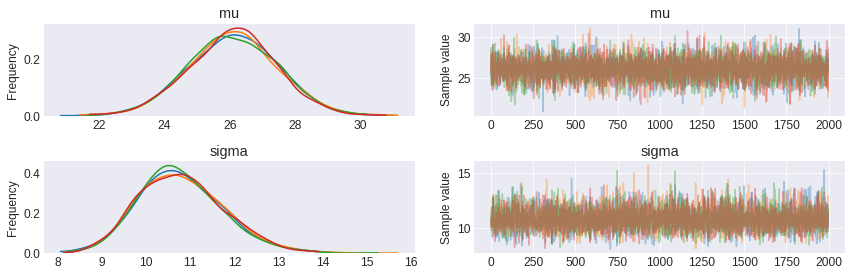

In [313]:
pm.traceplot(trace_1, varnames=['mu', 'sigma']);

In [314]:
pm.summary(trace_1, varnames=['mu', 'sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,26.075655,1.340333,0.015651,23.447193,28.636930,7113.778086,0.999800
sigma,10.781732,0.956274,0.011347,9.090661,12.767464,7368.570644,0.999916


We draw 20 samples of `post`.

In [8]:
with model_1:
    post_ppc = pm.sample_ppc(trace_1, samples=20, vars=[post])

100%|██████████| 20/20 [00:00<00:00, 342.48it/s]


Reproducing Figure 6.2

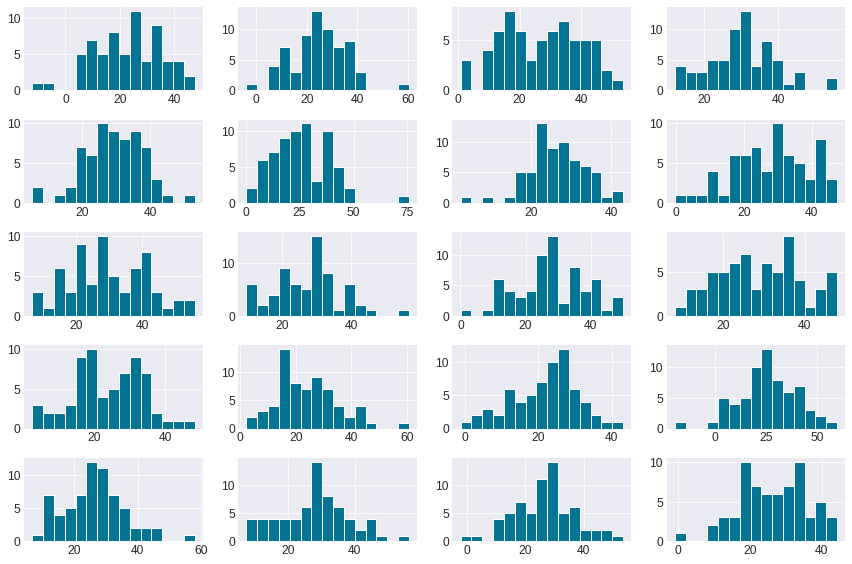

In [10]:
fig, axs = plt.subplots(figsize=(12, 8), ncols=4, nrows=5)

ind = 0
for j in range(5):
    for k in range(4):
        mm = np.mean(post_ppc['post'][ind, :]), 
        ss = np.std(post_ppc['post'][ind, :], ddof=1)
        post_num = np.random.normal(loc=mm, scale=ss, size=66)
        ind = ind + 1
        
#         Plotting each array
        axs[j, k].hist(post_num, bins=15, edgecolor='w', color='xkcd:sea blue')
fig.tight_layout()

Reproducing Figure 6.3

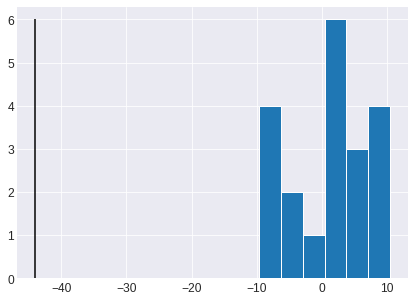

In [11]:
plt.figure(figsize=(7, 5))
_, _, _, = plt.hist(np.min(post_ppc['post'], axis=1), bins=6, edgecolor='w')
plt.vlines(-44, 0, 6);

Reproducing Figure 5.4 (a).

In [12]:
with model_1:
    sigma_ppc = pm.sample_ppc(trace_1, samples=200, vars=[sigma])

100%|██████████| 200/200 [00:00<00:00, 8322.94it/s]


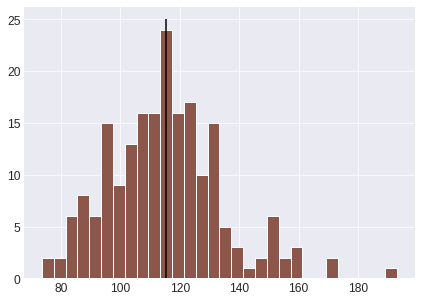

In [72]:
plt.figure(figsize=(7, 5))
_, _, _ = plt.hist(sigma_ppc['sigma']**2, bins=30, color='C5', edgecolor='w')
plt.vlines(np.std(nums, ddof=1)**2, 0, 25);

To find that *p*-value.

In [315]:
np.mean(sigma_ppc['sigma']**2 >= np.std(nums, ddof=1)**2)

0.47

Reproducing Figure 5.4 (b).

In [194]:
with model_1:
    post_ppc = pm.sample_ppc(trace_1, samples=200, vars=[post])

100%|██████████| 200/200 [00:00<00:00, 1717.85it/s]


In [206]:
def T_test(y, th):
    y_61, y_6 = np.percentile(y, 90), np.percentile(y, 10)
    return np.abs(y_61 - th) - np(y_6 - the)

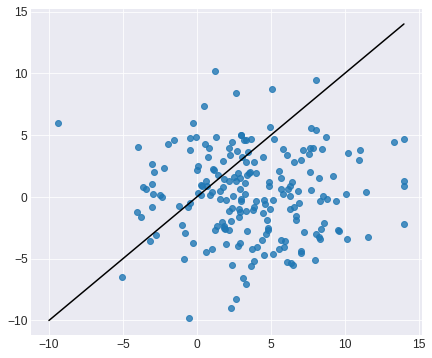

In [203]:
x_li = []
z_li = []

for i in range(post_ppc['post'].shape[0]):
    y_ = post_ppc['post'][i,:]
    mm, ss = np.mean(y_), np.std(y_, ddof=1)
    y_1 = np.random.normal(loc=mm, scale=ss, size=66)
    np.mean(y_1)

    z_li.append(T_test(y_1, mm))
    x_li.append(T_test(nums, mm))

plt.figure(figsize=(7, 6))
plt.scatter(x_li, z_li, alpha=0.8)
plt.plot([-10, 14], [-10, 14], color='k');

To find that *p*-value.

In [204]:
pr = [] 
for i, j in zip(x_li, z_li):
    if j >= i:
        pr.append(1)

sum(pr) / len(x_li)

0.265

## Example. Checking the assumption of independence in binomial trials

The data.

In [207]:
trials = np.array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0.])

In [247]:
with pm.Model() as model_2:
    
    theta = pm.Uniform('theta', lower=0, upper=1)
    obs = pm.Binomial('obs', n=trials.shape[0], p=theta, observed=np.sum(trials == 1))

In [248]:
model_2.check_test_point()

theta_interval__   -1.39
obs                -2.60
Name: Log-probability of test_point, dtype: float64

In [316]:
with model_2:
    trace_2 = pm.sample(draws=2000, tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:07<00:00, 3394.88draws/s]


/home/rosgori/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


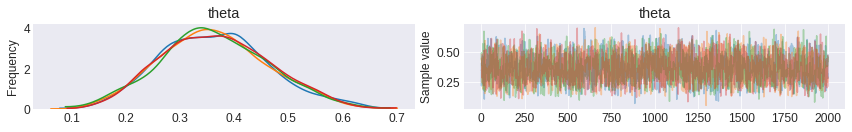

In [317]:
pm.traceplot(trace_2);

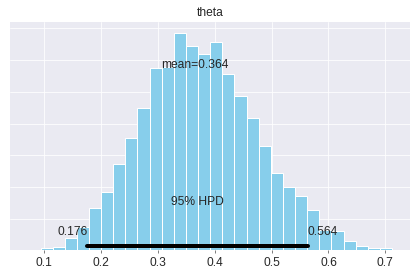

In [318]:
pm.plot_posterior(trace_2);

In [319]:
def n_switches(ll):
    """
    Function that takes a list of ones and zeros and returns
    the number of switches between 0 and 1 in the sequence.
    """
    return len(list(itertools.groupby(ll, lambda x: x == 0))) - 1

We draw $10\,000$ samples of `theta`.

In [303]:
with model_2:
    post_theta = pm.sample_ppc(trace_2, samples=10_000, vars=[theta])

100%|██████████| 10000/10000 [00:00<00:00, 28518.75it/s]


In [304]:
chang_li = []

for i in range(post_theta['theta'].shape[0]):
    ll = np.random.binomial(n=1, p=post_theta['theta'][i], size=20)
    chang_li.append(n_switches(ll))

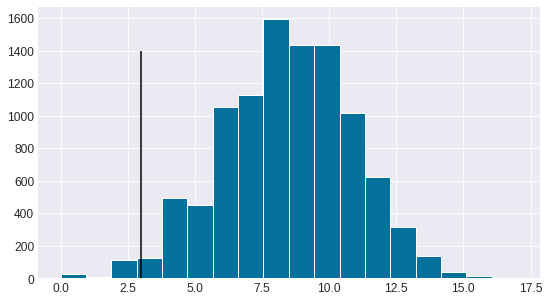

In [305]:
plt.figure(figsize=(9, 5))
_, _, _ = plt.hist(chang_li, bins=18, edgecolor='w', color='xkcd:ocean blue')
plt.vlines(3, 0, 1400);

To find the *p*-value.

In [306]:
np.mean(np.array(chang_li) >= 3)

0.9849

In [320]:
%load_ext watermark

In [321]:
%watermark -iv -v -p theano,scipy,matplotlib -m

numpy       1.15.0
pymc3       3.5
seaborn     0.9.0
CPython 3.6.6
IPython 7.1.1

theano 1.0.2
scipy 1.1.0
matplotlib 3.0.1

compiler   : GCC 7.2.0
system     : Linux
release    : 4.4.0-139-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
